# TCGA-KIPAN Analysis Demo

- **Cohort**: Focuses on the TCGA-KIPAN dataset, a vital resource merging three major kidney cancer subtypes:
    - `Kidney Renal Clear Cell Carcinoma` (KIRC)
    - `Kidney Renal Papillary Cell Carcinoma` (KIRP)
    - `Kidney Chromophobe `(KICH)

- **Goal**: Perform histological subtype classification.
- **Prediction Target**: Predict the specific kidney cancer subtype (`KIRC`, `KIRP`, or `KICH`) from its multi-omics profile.

**Data Source:** Broad Institute FireHose (`http://firebrowse.org/?cohort=KIPAN`)

In [ ]:
import pandas as pd
from pathlib import Path
root = Path("/home/vicente/Github/BioNeuralNet/KIPAN")

mirna_raw = pd.read_csv(root/"KIPAN.miRseq_RPKM_log2.txt", sep="\t",index_col=0,low_memory=False)                            
rna_raw = pd.read_csv(root / "KIPAN.uncv2.mRNAseq_RSEM_normalized_log2.txt", sep="\t",index_col=0,low_memory=False)
meth_raw = pd.read_csv(root/"KIPAN.meth.by_mean.data.txt", sep='\t',index_col=0,low_memory=False)
clinical_raw = pd.read_csv(root / "KIPAN.clin.merged.picked.txt",sep="\t", index_col=0, low_memory=False)

# display all shapes and first few rows of each dataset
display(mirna_raw.iloc[:3,:5])
display(mirna_raw.shape)

display(rna_raw.iloc[:3,:5])
display(meth_raw.shape)

display(meth_raw.iloc[:3,:5])
display(meth_raw.shape)

display(clinical_raw.iloc[:3,:5])
display(clinical_raw.shape)

,TCGA-KL-8323-01,TCGA-KL-8324-11,TCGA-KL-8324-01,TCGA-KL-8325-01,TCGA-KL-8326-11
gene,,,,,
hsa-let-7a-1,13.350564,12.669290,12.138842,12.186424,12.251624
hsa-let-7a-2,14.345422,13.671356,13.139199,13.182016,13.244735
hsa-let-7a-3,13.354717,12.696054,12.157156,12.178790,12.260827


(472, 1005)

,TCGA-KL-8323-01,TCGA-KL-8324-11,TCGA-KL-8324-01,TCGA-KL-8325-01,TCGA-KL-8326-11
gene,,,,,
?|100133144,3.145221,2.847776,3.356102,2.591009,2.097307
?|100134869,2.462733,2.555203,4.644127,3.272561,3.044499
?|10357,6.624215,6.822777,5.916350,6.813293,6.846008


(20117, 867)

,TCGA-KL-8323-01,TCGA-KL-8324-01,TCGA-KL-8325-01,TCGA-KL-8326-01,TCGA-KL-8327-01
Hybridization REF,,,,,
Composite Element REF,Beta_Value,Beta_Value,Beta_Value,Beta_Value,Beta_Value
A1BG,0.586272204702,0.258615822462,0.346998160003,0.303477029822,0.31424190458
A1CF,0.612681857814,0.585391864334,0.469213665938,0.572474360793,0.595785276504


(20117, 867)

,tcga-kl-8328,tcga-kl-8339,tcga-km-8439,tcga-km-8441,tcga-km-8442
Hybridization REF,,,,,
Composite Element REF,value,value,value,value,value
years_to_birth,60,67,30,61,38
vital_status,0,1,0,0,0


(20, 941)

## Data Processing Summary

1. **Transpose Data:** All raw data (miRNA, RNA, etc.) is flipped so rows represent patients and columns represent features.
2. **Standardize Patient IDs:** Patient IDs in all tables are cleaned to the 12-character TCGA format (e.g., `TCGA-AB-1234`) for matching.
3. **Handle Duplicates:** Duplicate patient rows are averaged in the omics data. The first entry is kept for duplicate patients in the clinical data.
4. **Find Common Patients:** The script identifies the list of patients that exist in *all* datasets.
5. **Subset Data:** All data tables are filtered down to *only* this common list of patients, ensuring alignment.
6. **Extract Target:** The `histological_type` column is pulled from the processed clinical data to be used as the prediction target (y-variable).

In [ ]:
mirna = mirna_raw.T
rna = rna_raw.T
meth = meth_raw.T
clinical = clinical_raw.T

print(f"miRNA (samples, features): {mirna.shape}")
print(f"RNA (samples, features): {rna.shape}")
print(f"Methylation (samples, features): {meth.shape}")
print(f"Clinical (samples, features): {clinical.shape}")

def trim_barcode(idx):
    return idx.to_series().str.slice(0, 12)

# standarized patient IDs across all files
meth.index = trim_barcode(meth.index)
rna.index = trim_barcode(rna.index)
mirna.index = trim_barcode(mirna.index)
clinical.index = clinical.index.str.upper()
clinical.index.name = "Patient_ID"

# convert all data to numeric, coercing errors to NaN
meth = meth.apply(pd.to_numeric, errors='coerce')
rna = rna.apply(pd.to_numeric, errors='coerce')
mirna = mirna.apply(pd.to_numeric, errors='coerce')

# for any duplicate columns in the omics data, we average their values
meth = meth.groupby(meth.index).mean()
rna = rna.groupby(rna.index).mean()
mirna = mirna.groupby(mirna.index).mean()

# for any duplicate rows in the clinical data, we keep the first occurrence
clinical = clinical[~clinical.index.duplicated(keep='first')]

print(f"\nMethylation shape: {meth.shape}")
print(f"RNA shape: {rna.shape}")
print(f"miRNA shape: {mirna.shape}")
print(f"Clinical shape: {clinical.shape}")

for df in [meth, rna, mirna]:
    df.columns = df.columns.str.replace(r"\?", "unknown_", regex=True)
    df.columns = df.columns.str.replace(r"\|", "_", regex=True)
    df.columns = df.columns.str.replace("-", "_", regex=False)
    df.columns = df.columns.str.replace(r"_+", "_", regex=True)
    df.columns = df.columns.str.strip("_")
    
    df.fillna(df.mean(), inplace=True)

# to see which pateints are common across all data files
common_patients = sorted(list(set(meth.index)&set(rna.index)&set(mirna.index)&set(clinical.index)))

print(f"\nFound: {len(common_patients)} patients across all data types.")

# subset to only common patients
meth_processed = meth.loc[common_patients]
rna_processed= rna.loc[common_patients]
mirna_processed = mirna.loc[common_patients]
clinical_processed = clinical.loc[common_patients]

# extract target labels from clinical data
targets = clinical_processed['histological_type']

miRNA (samples, features): (1005, 472)
RNA (samples, features): (1020, 18272)
Methylation (samples, features): (867, 20117)
Clinical (samples, features): (941, 20)

Methylation shape: (660, 20117)
RNA shape: (889, 18272)
miRNA shape: (873, 472)
Clinical shape: (941, 20)

Found: 658 patients across all data types.


In [3]:
display(mirna_processed.iloc[:3,:5])
display(mirna_processed.shape)

display(rna_processed.iloc[:3,:5])
display(rna_processed.shape)

display(meth_processed.iloc[:3,:5])
display(meth_processed.shape)

display(clinical_processed.iloc[:3,:5])
display(clinical_processed.shape)

display(targets.value_counts())

gene,hsa_let_7a_1,hsa_let_7a_2,hsa_let_7a_3,hsa_let_7b,hsa_let_7c
TCGA-2K-A9WE,12.933499,13.933025,12.938528,12.861969,11.474055
TCGA-2Z-A9J1,12.535658,13.536437,12.531655,12.710724,10.355773
TCGA-2Z-A9J2,11.832278,12.838388,11.840725,11.038718,8.360210


(658, 472)

gene,unknown_100133144,unknown_100134869,unknown_10357,unknown_10431,unknown_155060
TCGA-2K-A9WE,2.336112,2.520498,5.772965,9.610685,8.198804
TCGA-2Z-A9J1,3.006962,3.558929,6.177374,10.177077,7.656137
TCGA-2Z-A9J2,1.516973,1.736691,4.853207,10.345265,6.263288


(658, 18272)

Hybridization REF,Composite Element REF,A1BG,A1CF,A2BP1,A2LD1
TCGA-2K-A9WE,NaN,0.498835,0.814418,0.536619,0.771750
TCGA-2Z-A9J1,NaN,0.400956,0.554575,0.517050,0.505130
TCGA-2Z-A9J2,NaN,0.438116,0.656936,0.535795,0.678655


(658, 20117)

Hybridization REF,Composite Element REF,years_to_birth,vital_status,days_to_death,days_to_last_followup
Patient_ID,,,,,
TCGA-2K-A9WE,value,53,0,NaN,214
TCGA-2Z-A9J1,value,71,0,NaN,2298
TCGA-2Z-A9J2,value,71,0,NaN,1795


(658, 20)

histological_type
kidney clear cell renal carcinoma        318
kidney papillary renal cell carcinoma    274
kidney chromophobe                        66
Name: count, dtype: int64

In [4]:
import bioneuralnet as bnn

# drop unwanted columns from clinical data
clinical_processed.drop(columns=["Composite Element REF"], errors="ignore", inplace=True)

# we transform the methylation beta values to M-values and drop unwanted columns
meth_m = meth_processed.drop(columns=["Composite Element REF"], errors="ignore")

# convert beta values to M-values using bioneuralnet utility with small epsilon to avoid log(0)
meth_m = bnn.utils.beta_to_m(meth_m, eps=1e-6) 

# lastly we turn the target labels into numerical classes
mapping = {"kidney clear cell renal carcinoma": 0, "kidney papillary renal cell carcinoma": 1, "kidney chromophobe": 2}
target_labels = targets.map(mapping).to_frame(name="target")

# as a safety check we align the indices once more
X_meth = meth_m.loc[common_patients]
X_rna = rna_processed.loc[common_patients]
X_mirna = mirna_processed.loc[common_patients]
Y_labels = target_labels.loc[common_patients]
clinical_final = clinical_processed.loc[common_patients]

print(f"\nDNA_Methylation shape: {X_meth.shape}")
print(f"RNA shape: {X_rna.shape}")
print(f"miRNA shape: {X_mirna.shape}")
print(f"Clinical shape: {clinical_final.shape}")
print(Y_labels.value_counts())

2025-11-08 15:12:24,843 - bioneuralnet.utils.data - INFO - Starting Beta-to-M value conversion (shape: (658, 20116)). Epsilon: 1e-06
2025-11-08 15:12:25,944 - bioneuralnet.utils.data - INFO - Beta-to-M conversion complete.



DNA_Methylation shape: (658, 20116)
RNA shape: (658, 18272)
miRNA shape: (658, 472)
Clinical shape: (658, 19)
target
0         318
1         274
2          66
Name: count, dtype: int64


## Feature Selection Methodology

### Supported Methods and Interpretation

**BioNeuralNet** provides three techniques for feature selection, allowing for different views of the data's statistical profile:

- **Variance Thresholding:** Identifies features with the **highest overall variance** across all samples.

- **ANOVA F-test:** Pinpoints features that best **distinguish between the target classes** (KIRC, KIRP, and KICH).

- **Random Forest Importance:** Assesses **feature utility** based on its contribution to a predictive non-linear model.

### KIPAN Cohort Selection Strategy

A dimensionality reduction step was essential for managing the high-feature-count omics data:

- **High-Feature Datasets:** Both DNA Methylation (20,116) and RNA (18,272) required significant feature reduction.

- **Filtering Process:** The **top 6,000 features** were initially extracted from the Methylation and RNA datasets using all three methods.

- **Final Set:** A consensus set was built by finding the intersection of features selected by the ANOVA F-test and Random Forest Importance, ensuring both statistical relevance and model-based utility.

- **Low-Feature Datasets:** The miRNA data (472 features) was passed through **without selection**, as its feature count was already manageable.

In [5]:
import bioneuralnet as bnn

# feature selection
meth_highvar = bnn.utils.select_top_k_variance(X_meth, k=6000)
rna_highvar = bnn.utils.select_top_k_variance(X_rna, k=6000)

meth_af = bnn.utils.top_anova_f_features(X_meth, Y_labels, max_features=6000)
rna_af = bnn.utils.top_anova_f_features(X_rna, Y_labels, max_features=6000)

meth_rf = bnn.utils.select_top_randomforest(X_meth, Y_labels, top_k=6000)
rna_rf = bnn.utils.select_top_randomforest(X_rna, Y_labels, top_k=6000)

meth_var_set = set(meth_highvar.columns)
meth_anova_set = set(meth_af.columns)
meth_rf_set = set(meth_rf.columns)

rna_var_set = set(rna_highvar.columns)
rna_anova_set = set(rna_af.columns)
rna_rf_set = set(rna_rf.columns)

meth_inter1 = list(meth_anova_set & meth_var_set)
meth_inter2 = list(meth_rf_set & meth_var_set)
meth_inter3 = list(meth_anova_set & meth_rf_set)
meth_all_three = list(meth_anova_set & meth_var_set & meth_rf_set)

rna_inter4 = list(rna_anova_set & rna_var_set)
rna_inter5 = list(rna_rf_set & rna_var_set)
rna_inter6 = list(rna_anova_set & rna_rf_set)
rna_all_three = list(rna_anova_set & rna_var_set & rna_rf_set)

2025-11-08 15:12:53,133 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-11-08 15:12:53,133 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-11-08 15:12:53,134 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
2025-11-08 15:12:53,224 - bioneuralnet.utils.preprocess - INFO - Selected top 6000 features by variance
2025-11-08 15:12:55,954 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-11-08 15:12:55,955 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-11-08 15:12:55,955 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
2025-11-08 15:12:56,036 - bioneuralnet.utils.preprocess - INFO - Selected top 6000 features by variance
2025-11-08 15:12:58,995 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-11-08 15:12:58,995 - bioneuralnet.

In [6]:
print("FROM THE 6000 Methylation feature selection:\n")
print(f"Anova-F & variance selection share: {len(meth_inter1)} features")
print(f"Random Forest & variance selection share: {len(meth_inter2)} features")
print(f"Anova-F & Random Forest share: {len(meth_inter3)} features")
print(f"All three methods agree on: {len(meth_all_three)} features")

FROM THE 6000 Methylation feature selection:

Anova-F & variance selection share: 1875 features
Random Forest & variance selection share: 1656 features
Anova-F & Random Forest share: 2102 features
All three methods agree on: 666 features


In [7]:
print("\nFROM THE 6000 RNA feature selection:\n")
print(f"Anova-F & variance selection share: {len(rna_inter4)} features")
print(f"Random Forest & variance selection share: {len(rna_inter5)} features")
print(f"Anova-F & Random Forest share: {len(rna_inter6)} features")
print(f"All three methods agree on: {len(rna_all_three)} features")


FROM THE 6000 RNA feature selection:

Anova-F & variance selection share: 2271 features
Random Forest & variance selection share: 2141 features
Anova-F & Random Forest share: 2284 features
All three methods agree on: 943 features


## Feature Selection Summary: ANOVA-RF Intersection

The final set of features was determined by the **intersection** of those highlighted by the **ANOVA F-test** and **Random Forest Importance**. This methodology provides a balanced filter, capturing features with both high class-separability (ANOVA) and significant predictive value in a non-linear model (Random Forest). The resulting feature pool is considered highly relevant for the subsequent modeling tasks.

### Feature Overlap Results

The table below quantifies the shared features identified by the different selection techniques for each omics type.

| Omics Data Type | ANOVA-F & Variance | RF & Variance | ANOVA-F & Random Forest (Selected) | All Three Agree |
| :--- | :--- | :--- | :--- | :--- |
| **Methylation** | 1,875 features | 1,656 features | **2,102 features** | 666 features |
| **RNA** | 2,271 features | 2,141 features | **2,284 features** | 943 features |

In [8]:
X_meth_selected = X_meth[meth_inter3]
X_rna_selected = X_rna[rna_inter6]

print("\nFinal Shapes for Modeling")
print(f"Methylation (X1): {X_meth_selected.shape}")
print(f"RNA-Seq (X2): {X_rna_selected.shape}")
print(f"miRNA-Seq (X3): {X_mirna.shape}")
print(f"Labels (Y): {Y_labels.shape}")


Final Shapes for Modeling
Methylation (X1): (658, 2102)
RNA-Seq (X2): (658, 2284)
miRNA-Seq (X3): (658, 472)
Labels (Y): (658, 1)


## Data Availability

To facilitate rapid experimentation and reproduction of our results, the fully processed and feature-selected dataset used in this analysis has been made available directly within the package.

Users can load this dataset, bypassing all preceding data acquisition, preprocessing, and feature selection steps. This allows users to proceed immediately from this step.

In [1]:
import bioneuralnet as bnn

tgca_kipan = bnn.datasets.DatasetLoader("kipan")
display(tgca_kipan.shape)

# The dataset is returned as a dictionary. We extract each file independetly based on the name (Key).
dna_meth = tgca_kipan.data["meth"]
rna = tgca_kipan.data["rna"]
mirna = tgca_kipan.data["mirna"]
clinical = tgca_kipan.data["clinical"]
target = tgca_kipan.data["target"]

{'mirna': (658, 472),
 'target': (658, 1),
 'clinical': (658, 19),
 'rna': (658, 2284),
 'meth': (658, 2102)}

In [2]:
clinical.columns

Index(['years_to_birth', 'vital_status', 'days_to_death',
       'days_to_last_followup', 'tumor_tissue_site', 'pathologic_stage',
       'pathology_T_stage', 'pathology_N_stage', 'pathology_M_stage', 'gender',
       'date_of_initial_pathologic_diagnosis', 'days_to_last_known_alive',
       'radiation_therapy', 'karnofsky_performance_score', 'histological_type',
       'number_pack_years_smoked', 'year_of_tobacco_smoking_onset', 'race',
       'ethnicity'],
      dtype='object')

In [2]:
# for more details on the preprocessing functions, see `bioneuralnet.utils.preprocess`
clinical_preprocessed = bnn.utils.preprocess_clinical(
    clinical, 
    target, 
    top_k=4, 
    scale=False,
    ignore_columns=[
        # target-related or outcome-related
        "histological_type",
        "pathologic_stage",
        "pathology_T_stage",
        "pathology_N_stage",
        "pathology_M_stage",
        "vital_status",
        "days_to_death",
        "days_to_last_followup",
        "days_to_last_known_alive",
        "radiation_therapy",
        "date_of_initial_pathologic_diagnosis" 
    ]
)

display(clinical_preprocessed.iloc[:3,:5])

2025-11-12 21:13:48,702 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-11-12 21:13:48,702 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 1673 NaNs after median imputation
2025-11-12 21:13:48,702 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
2025-11-12 21:13:48,810 - bioneuralnet.utils.preprocess - INFO - Selected top 4 features by RandomForest importance


,years_to_birth,number_pack_years_smoked,ethnicity_not hispanic or latino,karnofsky_performance_score
Patient_ID,,,,
TCGA-2K-A9WE,53.0,27.0,True,90.0
TCGA-2Z-A9J1,71.0,27.0,True,90.0
TCGA-2Z-A9J2,71.0,30.0,True,90.0


In [3]:
import pandas as pd

X_train_full = pd.concat([dna_meth, rna, mirna], axis=1)

print(f"Nan values in X_train_full: {X_train_full.isna().sum().sum()}")
X_train_full = X_train_full.dropna()
print(f"Nan value in X_train_full after dropping: {X_train_full.isna().sum().sum()}")

print(f"X_train_full shape: {X_train_full.shape}")
# building the graph using the similarity graph function with k=15
A_train = bnn.utils.gen_similarity_graph(X_train_full, k=15)

print(f"\nNetwork shape: {A_train.shape}")

Nan values in X_train_full: 0
Nan value in X_train_full after dropping: 0
X_train_full shape: (658, 4858)

Network shape: (4858, 4858)


## Reproducibility and Seeding

To ensure our experimental results are fully reproducible, a single global seed is set at the beginning of the analysis.

This utility function propagates the seed to all sources of randomness, including `random`, `numpy`, and `torch` (for both CPU and GPU). Critically, it also configures the PyTorch cuDNN backend to use deterministic algorithms.

**for each DPMON outer iteration, the seed is incremented to generate a different internal test/train split.**

In [7]:
import bioneuralnet as bnn

SEED = 1804
bnn.utils.set_seed(SEED)

2025-11-12 21:21:43,031 - bioneuralnet.utils.data - INFO - Setting global seed for reproducibility to: 1804
2025-11-12 21:21:43,032 - bioneuralnet.utils.data - INFO - CUDA available. Applying seed to all GPU operations
2025-11-12 21:21:43,032 - bioneuralnet.utils.data - INFO - Seed setting complete


---

## Classification using DPMON: Training and Evaluation

- Run 5 outer iterations, each with a different seed.
- Each iteration performs hyperparameter tuning.
- After tuning, train `repeat_num = 3` models with the best hyperparameters.
- Collect predictions from the best model of each iteration.
- Compute **Accuracy**, **F1 Weighted**, and **F1 Macro +/- standard deviation** across iterations.

This demonstrates the **end-to-end BioNeuralNet pipeline** in action.

Each of the hyperpapter tables shows the "best" hyperparameters found by `ray.tune` for each of the 5 outer runs, along with the *internal* average accuracy of the 3 models trained with those parameters.

The final results sable shows the   the mean performance of the "best" model from each of the 5 runs, scored against the full dataset.

### SAGE Analysis of Hyperparameter Optimization

| Seed | Internal Avg Acc | Internal Std Dev | gnn_layer_num | gnn_hidden_dim | lr | weight_decay | nn_hidden_dim1 | nn_hidden_dim2 | num_epochs |
|:---|---:|---:|---:|---:|---:|---:|---:|---:|---:|
| 1804 | 0.9078 | 0.1228 | 16 | 4 | 0.0053 | 0.0026 | 16 | 16 | 8192 |
| 1805 | 0.9970 | 0.0053 | 16 | 8 | 0.0003 | 0.0185 | 128 | 128 | 1024 |
| 1806 | 1.0000 | 0.0000 | 2 | 8 | 0.0003 | 0.0398 | 128 | 64 | 8192 |
| 1807 | 0.6606 | 0.2558 | 4 | 128 | 0.0002 | 0.0011 | 8 | 4 | 64 |
| 1808 | 0.9823 | 0.0307 | 8 | 32 | 0.0056 | 0.0001 | 32 | 64 | 2048 |


### SAGE Final Results

| | Mean | Std Dev |
|:---|---:|---:|
| **Accuracy** | **0.9903** | **0.0173** |
| **F1 Weighted** | **0.9903** | **0.0173** |
| **F1 Macro** | **0.9876** | **0.0203** |


### GCN Analysis of Hyperparameter Optimization

| Seed | Average Accuracy | Std Deviation | gnn_layer_num | gnn_hidden_dim | lr | weight_decay | nn_hidden_dim1 | nn_hidden_dim2 | num_epochs |
|:---|---:|---:|---:|---:|---:|---:|---:|---:|---:|
| 1804 | 0.9696 | 0.0450 | 64 | 8 | 0.0046 | 0.0013 | 64 | 128 | 512 |
| 1805 | 0.8698 | 0.2255 | 16 | 8 | 0.0003 | 0.0185 | 128 | 128 | 1024 |
| 1806 | 0.9245 | 0.0521 | 8 | 32 | 0.0207 | 0.0001 | 32 | 128 | 8192 |
| 1807 | 0.9650 | 0.0227 | 2 | 4 | 0.0004 | 0.0004 | 8 | 128 | 64 |
| 1808 | 0.8840 | 0.0207 | 128 | 4 | 0.0030 | 0.0788 | 8 | 128 | 8192 |

### GCN Results

| | Mean | Std Dev |
|:---|---:|---:|
| Accuracy | 0.9720 | 0.0379 |
| F1 Weighted | 0.9631 | 0.0557 |
| F1 Macro | 0.9150 | 0.1410 |


### GAT Analysis of Hyperparameter Optimization

| Seed | Average Accuracy | Std Deviation | gnn_layer_num | gnn_hidden_dim | lr | weight_decay | nn_hidden_dim1 | nn_hidden_dim2 | num_epochs |
|:---|---:|---:|---:|---:|---:|---:|---:|---:|---:|
| 1804 | 0.9990 | 0.0018 | 64 | 16 | 0.0003 | 0.0001 | 64 | 16 | 2048 |
| 1805 | 0.7837 | 0.2446 | 16 | 8 | 0.0003 | 0.0185 | 128 | 128 | 1024 |
| 1806 | 0.6393 | 0.5367 | 8 | 32 | 0.0207 | 0.0001 | 32 | 128 | 8192 |
| 1807 | 0.6844 | 0.2320 | 8 | 16 | 0.0267 | 0.0480 | 4 | 4 | 1024 |
| 1808 | 0.9681 | 0.0513 | 2 | 4 | 0.0212 | 0.0002 | 8 | 32 | 2048 |

### GAT Results

| | Mean | Std Dev |
|:---|---:|---:|
| Accuracy | 0.9626 | 0.0575 |
| F1 Weighted | 0.9546 | 0.0732 |
| F1 Macro | 0.9107 | 0.1569 |

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import f1_score, accuracy_score
from bioneuralnet.downstream_task import DPMON

output_dir_base_sage =  Path("/home/vicente/Github/BioNeuralNet/dpmon_results_SAGE_FINAL/kipan")
target = target.rename(columns={"target": "phenotype"})

n_repeats = 5
all_preds = []

for r in range(n_repeats):
    bnn.utils.set_seed(SEED+r)
    dpmon_repeat = DPMON(
        adjacency_matrix=A_train,
        omics_list=[dna_meth, rna, mirna],
        phenotype_data=target,
        clinical_data=clinical_preprocessed,
        repeat_num=3,
        model='SAGE',
        tune=True,
        gpu=True,
        cuda=0,
        output_dir=output_dir_base_sage,
    )
    
    predictions_df, _ = dpmon_repeat.run()
    all_preds.append(predictions_df["Predicted"].values)

all_preds = np.array(all_preds)

f1_macro_list = [f1_score(target, pred, average='macro') for pred in all_preds]
f1_weighted_list = [f1_score(target, pred, average='weighted') for pred in all_preds]
accuracy_list = [accuracy_score(target, pred) for pred in all_preds]

avg_f1_macro = np.mean(f1_macro_list)
std_f1_macro = np.std(f1_macro_list)

avg_f1_weighted = np.mean(f1_weighted_list)
std_f1_weighted = np.std(f1_weighted_list)

avg_acc = np.mean(accuracy_list)
std_acc = np.std(accuracy_list)

print(f"Accuracy: {avg_acc:.4f} +/- {std_acc:.4f}")
print(f"F1 Weighted: {avg_f1_weighted:.4f} +/- {std_f1_weighted:.4f}")
print(f"F1 Macro: {avg_f1_macro:.4f} +/- {std_f1_macro:.4f}")

2025-11-12 21:21:50,322 - bioneuralnet.utils.data - INFO - Setting global seed for reproducibility to: 1804
2025-11-12 21:21:50,322 - bioneuralnet.utils.data - INFO - CUDA available. Applying seed to all GPU operations
2025-11-12 21:21:50,323 - bioneuralnet.utils.data - INFO - Seed setting complete
2025-11-12 21:21:50,323 - bioneuralnet.downstream_task.dpmon - INFO - Output directory set to: /home/vicente/Github/BioNeuralNet/dpmon_results_SAGE_FINAL/kipan
2025-11-12 21:21:50,323 - bioneuralnet.downstream_task.dpmon - INFO - Initialized DPMON with the provided parameters.
2025-11-12 21:21:50,323 - bioneuralnet.downstream_task.dpmon - INFO - Starting DPMON run.
2025-11-12 21:21:50,340 - bioneuralnet.downstream_task.dpmon - INFO - Running hyperparameter tuning for DPMON.
2025-11-12 21:21:50,341 - bioneuralnet.downstream_task.dpmon - INFO - Using GPU 0
2025-11-12 21:21:50,537 - bioneuralnet.downstream_task.dpmon - INFO - Number of nodes in network: 4858
2025-11-12 21:21:52,437 - bioneuraln

Accuracy: 0.9903 +/- 0.0173
F1 Weighted: 0.9903 +/- 0.0173
F1 Macro: 0.9876 +/- 0.0203


In [ ]:
output_dir_base_gcn = Path("/home/vicente/Github/BioNeuralNet/dpmon_results_GCN_FINAL/kipan")

n_repeats = 5
all_preds = []

for r in range(n_repeats):
    bnn.utils.set_seed(SEED+r)
    dpmon_repeat = DPMON(
        adjacency_matrix=A_train,
        omics_list=[dna_meth, rna, mirna],
        phenotype_data=target,
        clinical_data=clinical_preprocessed,
        repeat_num=3,
        model='GCN',
        tune=True,
        gpu=True,
        cuda=0,
        output_dir=output_dir_base_gcn,
    )
    
    predictions_df, _ = dpmon_repeat.run()
    all_preds.append(predictions_df["Predicted"].values)

all_preds = np.array(all_preds)

f1_macro_list = [f1_score(target, pred, average='macro') for pred in all_preds]
f1_weighted_list = [f1_score(target, pred, average='weighted') for pred in all_preds]
accuracy_list = [accuracy_score(target, pred) for pred in all_preds]

avg_f1_macro = np.mean(f1_macro_list)
std_f1_macro = np.std(f1_macro_list)

avg_f1_weighted = np.mean(f1_weighted_list)
std_f1_weighted = np.std(f1_weighted_list)

avg_acc = np.mean(accuracy_list)
std_acc = np.std(accuracy_list)

print(f"Accuracy: {avg_acc:.4f} +/- {std_acc:.4f}")
print(f"F1 Weighted: {avg_f1_weighted:.4f} +/- {std_f1_weighted:.4f}")
print(f"F1 Macro: {avg_f1_macro:.4f} +/- {std_f1_macro:.4f}")

2025-11-12 20:17:45,519 - bioneuralnet.utils.data - INFO - Setting global seed for reproducibility to: 1804
2025-11-12 20:17:45,520 - bioneuralnet.utils.data - INFO - CUDA available. Applying seed to all GPU operations
2025-11-12 20:17:45,520 - bioneuralnet.utils.data - INFO - Seed setting complete
2025-11-12 20:17:45,520 - bioneuralnet.downstream_task.dpmon - INFO - Output directory set to: /home/vicente/Github/BioNeuralNet/dpmon_results_GCN_FINAL/kipan
2025-11-12 20:17:45,521 - bioneuralnet.downstream_task.dpmon - INFO - Initialized DPMON with the provided parameters.
2025-11-12 20:17:45,521 - bioneuralnet.downstream_task.dpmon - INFO - Starting DPMON run.
2025-11-12 20:17:45,550 - bioneuralnet.downstream_task.dpmon - INFO - Running hyperparameter tuning for DPMON.
2025-11-12 20:17:45,550 - bioneuralnet.downstream_task.dpmon - INFO - Using GPU 0
2025-11-12 20:17:45,753 - bioneuralnet.downstream_task.dpmon - INFO - Number of nodes in network: 4858
2025-11-12 20:17:47,739 - bioneuralne

Accuracy: 0.9720 +/- 0.0379
F1 Weighted: 0.9631 +/- 0.0557
F1 Macro: 0.9150 +/- 0.1410


In [ ]:
output_dir_base_gat = Path("/home/vicente/Github/BioNeuralNet/dpmon_results_GAT_FINAL/kipan")

n_repeats = 5
all_preds = []

for r in range(n_repeats):
    bnn.utils.set_seed(SEED+r)
    dpmon_repeat = DPMON(
        adjacency_matrix=A_train,
        omics_list=[dna_meth, rna, mirna],
        phenotype_data=target,
        clinical_data=clinical_preprocessed,
        repeat_num=3,
        model='GAT',
        tune=True,
        gpu=True,
        cuda=0,
        output_dir=output_dir_base_gat,
    )
    
    predictions_df, _ = dpmon_repeat.run()
    all_preds.append(predictions_df["Predicted"].values)

all_preds = np.array(all_preds)

f1_macro_list = [f1_score(target, pred, average='macro') for pred in all_preds]
f1_weighted_list = [f1_score(target, pred, average='weighted') for pred in all_preds]
accuracy_list = [accuracy_score(target, pred) for pred in all_preds]

avg_f1_macro = np.mean(f1_macro_list)
std_f1_macro = np.std(f1_macro_list)

avg_f1_weighted = np.mean(f1_weighted_list)
std_f1_weighted = np.std(f1_weighted_list)

avg_acc = np.mean(accuracy_list)
std_acc = np.std(accuracy_list)

print(f"Accuracy: {avg_acc:.4f} +/- {std_acc:.4f}")
print(f"F1 Weighted: {avg_f1_weighted:.4f} +/- {std_f1_weighted:.4f}")
print(f"F1 Macro: {avg_f1_macro:.4f} +/- {std_f1_macro:.4f}")

2025-11-12 20:24:38,492 - bioneuralnet.utils.data - INFO - Setting global seed for reproducibility to: 1804
2025-11-12 20:24:38,493 - bioneuralnet.utils.data - INFO - CUDA available. Applying seed to all GPU operations
2025-11-12 20:24:38,493 - bioneuralnet.utils.data - INFO - Seed setting complete
2025-11-12 20:24:38,493 - bioneuralnet.downstream_task.dpmon - INFO - Output directory set to: /home/vicente/Github/BioNeuralNet/dpmon_results_GAT_FINAL/kipan
2025-11-12 20:24:38,494 - bioneuralnet.downstream_task.dpmon - INFO - Initialized DPMON with the provided parameters.
2025-11-12 20:24:38,494 - bioneuralnet.downstream_task.dpmon - INFO - Starting DPMON run.
2025-11-12 20:24:38,512 - bioneuralnet.downstream_task.dpmon - INFO - Running hyperparameter tuning for DPMON.
2025-11-12 20:24:38,512 - bioneuralnet.downstream_task.dpmon - INFO - Using GPU 0
2025-11-12 20:24:38,731 - bioneuralnet.downstream_task.dpmon - INFO - Number of nodes in network: 4858
2025-11-12 20:24:40,860 - bioneuralne

Accuracy: 0.9626 +/- 0.0575
F1 Weighted: 0.9546 +/- 0.0732
F1 Macro: 0.9107 +/- 0.1569


---

## Classification using Baseline Models: Training and Evaluation

To perform a fair evaluation, we built a similar setup to what DPMON does internally:

* Run 5 outer iterations, each with a different seed.
* Each iteration splits the data into a 30% **Train** set and a 70% **Test** set.
* Hyperparameter tuning (`RandomizedSearchCV` with 3-fold CV) is run **only** on the 30% training set to find the best model.
* The single best-tuned model is then trained on the *entire* 30% train set and evaluated *once* on the unseen 70% test set.
* Compute **Accuracy**, **F1 Weighted**, and **F1 Macro +/- standard deviation** across the 5 outer iterations.

This provides a fair comparison against the tuned DPMON results.

### LogisticRegression: Best Hyperparameters per Seed

| Seed | model__C | model__penalty |
|:---|---:|:---|
| 1804 | 0.1417 | l2 |
| 1805 | 0.0014 | l2 |
| 1806 | 4.2236 | l2 |
| 1807 | 0.0170 | l2 |
| 1808 | 34.2874 | l2 |

### LogisticRegression: Final Results

| Metric | Score |
|:---|:---|
| Accuracy | 0.9553 +/- 0.0090 |
| F1 Weighted | 0.9557 +/- 0.0088 |
| F1 Macro | 0.9413 +/- 0.0124 |

### MLP: Best Hyperparameters per Seed

| Seed | model__activation | model__alpha | model__hidden_layer_sizes | model__learning_rate_init |
|:---|:---|---:|:---|---:|
| 1804 | tanh | 0.0004 | (100, 50) | 0.0045 |
| 1805 | tanh | 0.0007 | (50, 50) | 0.0011 |
| 1806 | tanh | 0.0031 | (100, 50) | 0.0025 |
| 1807 | relu | 0.0574 | (100,) | 0.0013 |
| 1808 | relu | 0.0055 | (100, 50) | 0.0071 |

### MLP: Final Results

| Metric | Score |
|:---|:---|
| Accuracy | 0.9362 +/- 0.0133 |
| F1 Weighted | 0.9379 +/- 0.0125 |
| F1 Macro | 0.9138 +/- 0.0170 |

### XGBoost: Best Hyperparameters per Seed

| Seed | model__colsample_bytree | model__learning_rate | model__max_depth | model__n_estimators | model__subsample |
|:---|---:|---:|---:|---:|---:|
| 1804 | 0.9 | 0.0201 | 9 | 317 | 0.7 |
| 1805 | 0.7 | 0.0351 | 6 | 246 | 0.9 |
| 1806 | 0.7 | 0.0266 | 8 | 417 | 0.7 |
| 1807 | 0.7 | 0.0518 | 9 | 447 | 0.7 |
| 1808 | 0.8 | 0.0422 | 5 | 478 | 0.8 |

### XGBoost: Final Results

| Metric | Score |
|:---|:---|
| Accuracy | 0.9527 +/- 0.0059 |
| F1 Weighted | 0.9529 +/- 0.0058 |
| F1 Macro | 0.9451 +/- 0.0106 |

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import loguniform, randint


X = pd.concat([dna_meth, rna, mirna, clinical_preprocessed], axis=1)
y = target['phenotype']
print(f"Successfully created X matrix with shape: {X.shape}")
print(f"Successfully created y vector with shape: {y.shape}")

all_results = {
    "LogisticRegression": {"acc": [], "f1_w": [], "f1_m": []},
    "MLP": {"acc": [], "f1_w": [], "f1_m": []},
    "XGBoost": {"acc": [], "f1_w": [], "f1_m": []},
}

all_results = {
    "LogisticRegression": {"acc": [], "f1_w": [], "f1_m": []},
    "MLP": {"acc": [], "f1_w": [], "f1_m": []},
    "XGBoost": {"acc": [], "f1_w": [], "f1_m": []},
}

N_REPEATS = 5
TEST_SPLIT_SIZE = .7
CV_FOLDS = 3
N_ITER_SEARCH = 10

pipe_lr = Pipeline([('scaler', StandardScaler()),
    ('model', LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        penalty=None 
    ))
])

pipe_mlp = Pipeline([('scaler', StandardScaler()),
    ('model', MLPClassifier(
        max_iter=500,
        early_stopping=True,
        n_iter_no_change=10
    ))
])

pipe_xgb = Pipeline([('scaler', StandardScaler()),
    ('model', XGBClassifier(
        eval_metric='logloss'
    ))
])

params_lr = {
    'model__penalty': ['l2'], 
    'model__C': loguniform(1e-4, 1e2)
}

params_mlp = {
    'model__hidden_layer_sizes': [(100,), (100, 50), (50, 50)],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': loguniform(1e-5, 1e-1),
    'model__learning_rate_init': loguniform(1e-4, 1e-2)
}

params_xgb = {
    'model__n_estimators': randint(100, 500),
    'model__learning_rate': loguniform(0.01, 0.3),
    'model__max_depth': randint(3, 10),
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

models_to_tune = {
    "LogisticRegression": (pipe_lr, params_lr),
    "MLP": (pipe_mlp, params_mlp),
    "XGBoost": (pipe_xgb, params_xgb)
}

for r in range(N_REPEATS):
    seed = SEED + r
    print(f"\nRunning Repeat {r+1}/{N_REPEATS} (Seed: {seed})")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=TEST_SPLIT_SIZE, 
        random_state=seed, 
        stratify=y)
    
    cv_splitter = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=seed)
    for name, (pipeline, params) in models_to_tune.items():
        print(f"Tuning {name}")
        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=params,
            n_iter=N_ITER_SEARCH,
            cv=cv_splitter,
            scoring='f1_weighted',
            n_jobs=-1,
            random_state=seed
        )
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            warnings.filterwarnings("ignore", category=UserWarning)
            search.fit(X_train, y_train)

        print(f"Best params for {name}: {search.best_params_}")
        
        best_model = search.best_estimator_
        preds = best_model.predict(X_test)

        acc = accuracy_score(y_test, preds)
        f1_w = f1_score(y_test, preds, average='weighted', zero_division=0)
        f1_m = f1_score(y_test, preds, average='macro', zero_division=0)

        all_results[name]["acc"].append(acc)
        all_results[name]["f1_w"].append(f1_w)
        all_results[name]["f1_m"].append(f1_m)

print(f"Tuned Model Results (Averaged over {N_REPEATS} runs)")
print(f"(Tuning was {N_ITER_SEARCH} iterations with {CV_FOLDS}fold CV)")

for model_name, metrics in all_results.items():
    avg_acc = np.mean(metrics["acc"])
    std_acc = np.std(metrics["acc"])
    
    avg_f1_w = np.mean(metrics["f1_w"])
    std_f1_w = np.std(metrics["f1_w"])
    
    avg_f1_m = np.mean(metrics["f1_m"])
    std_f1_m = np.std(metrics["f1_m"])

    print(f"Results for {model_name}:")
    print(f" Accuracy: {avg_acc:.4f} +/- {std_acc:.4f}")
    print(f" F1 Weighted: {avg_f1_w:.4f} +/- {std_f1_w:.4f}")
    print(f" F1 Macro: {avg_f1_m:.4f} +/- {std_f1_m:.4f}")


Successfully created X matrix with shape: (658, 4862)
Successfully created y vector with shape: (658,)

Running Repeat 1/5 (Seed: 1804)
Tuning LogisticRegression
Best params for LogisticRegression: {'model__C': 0.14169236219743603, 'model__penalty': 'l2'}
Tuning MLP
Best params for MLP: {'model__activation': 'tanh', 'model__alpha': 0.00038498823043905494, 'model__hidden_layer_sizes': (100, 50), 'model__learning_rate_init': 0.004492727016676559}
Tuning XGBoost
Best params for XGBoost: {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.020052178850793433, 'model__max_depth': 9, 'model__n_estimators': 317, 'model__subsample': 0.7}

Running Repeat 2/5 (Seed: 1805)
Tuning LogisticRegression
Best params for LogisticRegression: {'model__C': 0.0014356045234695239, 'model__penalty': 'l2'}
Tuning MLP
Best params for MLP: {'model__activation': 'tanh', 'model__alpha': 0.0006935088560541856, 'model__hidden_layer_sizes': (50, 50), 'model__learning_rate_init': 0.0010814563900350784}
Tuning XG

2025-11-12 22:19:09,094 - bioneuralnet.metrics.plot - INFO - Plotting multiple metrics: ['Accuracy', 'F1 Weighted', 'F1 Macro']


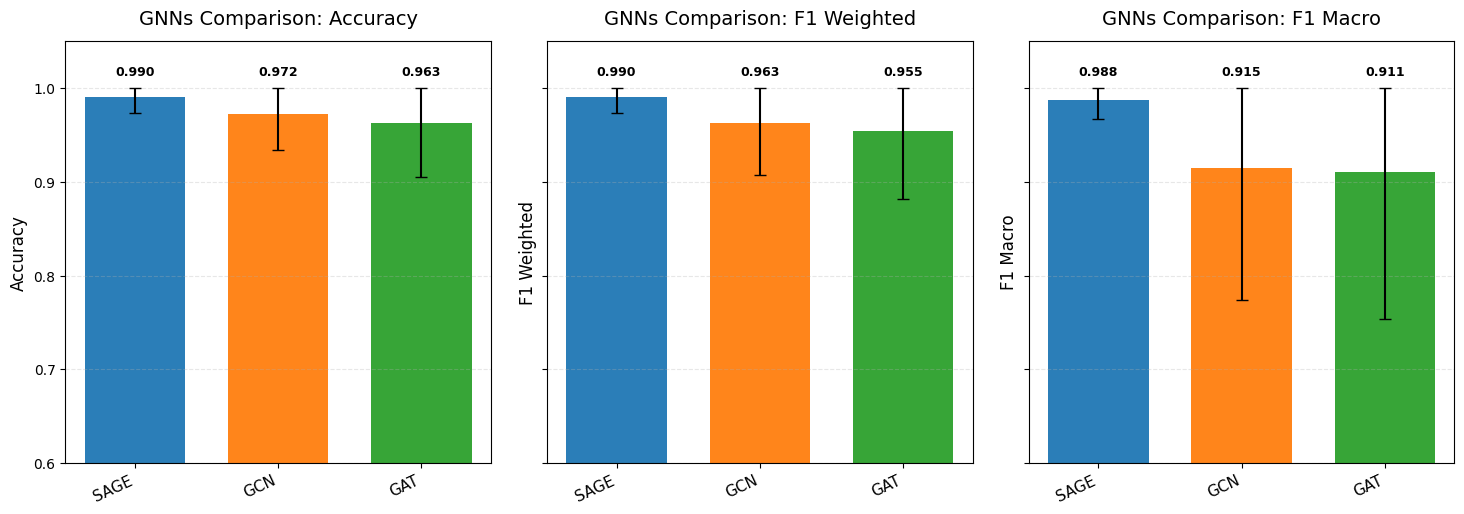

2025-11-12 22:19:09,213 - bioneuralnet.metrics.plot - INFO - Plotting multiple metrics: ['Accuracy', 'F1 Weighted', 'F1 Macro']


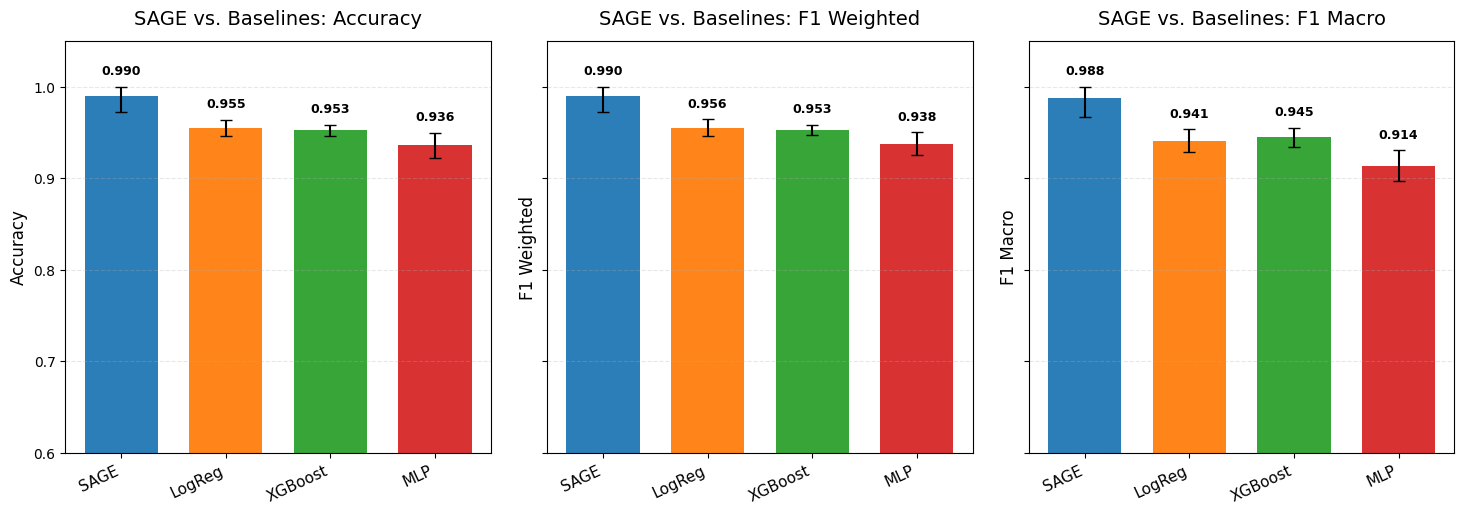

In [1]:
import bioneuralnet as bnn

gnn_plot_data = {
    "Accuracy": {
        "SAGE": (0.9903, 0.0173), 
        "GCN": (0.9720, 0.0379), 
        "GAT": (0.9626, 0.0575)
    },
    "F1 Weighted": {
        "SAGE": (0.9903, 0.0173), 
        "GCN": (0.9631, 0.0557), 
        "GAT": (0.9546, 0.0732)
    },
    "F1 Macro": {
        "SAGE": (0.9876, 0.0203), 
        "GCN": (0.9150, 0.1410), 
        "GAT": (0.9107, 0.1569)
    }
}

baseline_plot_data = {
    "Accuracy": {
        "SAGE": (0.9903, 0.0173), 
        "LogReg": (0.9553, 0.0090), 
        "XGBoost": (0.9527, 0.0059), 
        "MLP": (0.9362, 0.0133)
    },
    "F1 Weighted": {
        "SAGE": (0.9903, 0.0173), 
        "LogReg": (0.9557, 0.0088), 
        "XGBoost": (0.9529, 0.0058), 
        "MLP": (0.9379, 0.0125)
    },
    "F1 Macro": {
        "SAGE": (0.9876, 0.0203), 
        "LogReg": (0.9413, 0.0124), 
        "XGBoost": (0.9451, 0.0106), 
        "MLP": (0.9138, 0.0170)
    }
}


bnn.metrics.plot_multiple_metrics(
    gnn_plot_data,
    title_map={
        "Accuracy": "GNNs Comparison: Accuracy",
        "F1 Weighted": "GNNs Comparison: F1 Weighted",
        "F1 Macro": "GNNs Comparison: F1 Macro"
    }
)

bnn.metrics.plot_multiple_metrics(
    baseline_plot_data,
    title_map={
        "Accuracy": "SAGE vs. Baselines: Accuracy",
        "F1 Weighted": "SAGE vs. Baselines: F1 Weighted",
        "F1 Macro": "SAGE vs. Baselines: F1 Macro"
    }
)

